In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import pickle
import music21
import matplotlib.pyplot as plt

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists

from music21 import midi, note, stream, instrument, meter, key
import itertools
import random

import string
import pretty_midi

import phrase_segmentation
from phrase_segmentation import *

from pathlib import Path

# improve quality of plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

# add grid
import seaborn as sns
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
piece_path = Path("..") / "asap-dataset" / "Schubert" / "Impromptu_op.90_D.899" / "3"

annotations_files = glob.glob(os.path.join(piece_path, "*annotations.txt"))
midi_files = glob.glob(os.path.join(piece_path, "*.mid"))
annotations_files = [f for f in annotations_files if not f.endswith("midi_score_annotations.txt")]
midi_files = [f for f in midi_files if not f.endswith("midi_score.mid")]
annotations_files.sort()
midi_files.sort()

sig = 4
times_list, diff_list = read_diff_timings(annotations_files)
times = np.array(times_list)
diff = np.array(diff_list)

midis = [pretty_midi.PrettyMIDI(midi_path) for midi_path in midi_files]

velocity_curve = compute_all_smooth_velocity_curves(midis, times, 2)

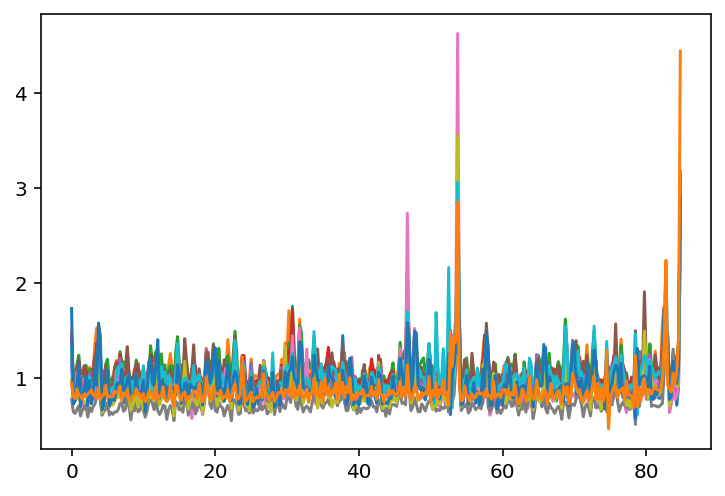

In [3]:
avg_diff = moving_average(diff, n=1)

plot_avg_diff(avg_diff, sig)

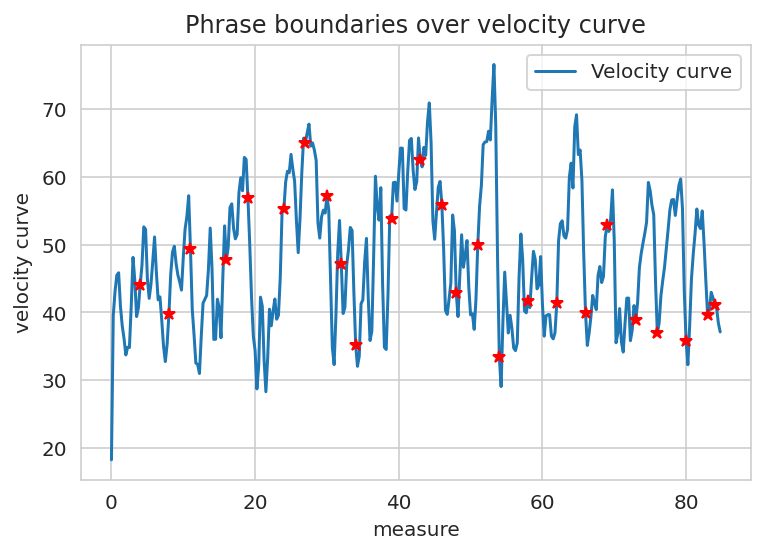

In [13]:
break_idx, breaks = performance_segmentation(avg_diff, times, velocity_curve)

In [15]:
beat_indices = np.arange(break_idx.shape[0])[break_idx]
measure_counts = (beat_indices) / 4 + 1
print(f"Found {measure_counts.shape} phrase boundaries!")
print(measure_counts)

zero_starting = measure_counts - 1
print(f"Zero starting for Tikz:")
print(zero_starting)

Found (25,) phrase boundaries!
[ 5.  9. 12. 17. 20. 25. 28. 31. 33. 35. 40. 44. 47. 49. 52. 55. 59. 63.
 67. 70. 74. 77. 81. 84. 85.]
Zero starting for Tikz:
[ 4.  8. 11. 16. 19. 24. 27. 30. 32. 34. 39. 43. 46. 48. 51. 54. 58. 62.
 66. 69. 73. 76. 80. 83. 84.]
